# Generate tier 3 scenarios


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyam
import pymagicc
import scmdata
import silicone.multiple_infillers as mi
import silicone.database_crunchers.quantile_rolling_windows as qrw

<IPython.core.display.Javascript object>

In [2]:
version = "v8"
basedir = f"../output/{version}/"
# Note that the chosen_files use an unrelated versioning, though this file should be stable.
hist = pyam.IamDataFrame("../output/chosen_files/v9/ssp245_harmonised.csv")
outdir = basedir + "tier3/"

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\output\chosen_files\v9\ssp245_harmonised.csv


In [3]:
complete_sr15 = pyam.IamDataFrame("../input/complete_sr15_emissions.csv").filter(region="World")

pyam.core - INFO: Reading file ..\input\complete_sr15_emissions.csv


In [4]:
sr15_em_int = complete_sr15.interpolate([2015, 2025, 2035, 2045, 2055, 2065, 2075, 2085, 2095])

# Harmonize
The harmonisation is done to the pre-harmonised SSP2-4.5 scenario (calculated in select_pathways).

In [5]:
co2tot = "Emissions|CO2"
co2afolu = "Emissions|CO2|AFOLU"
co2ei = "Emissions|CO2|Energy and Industrial Processes"

In [6]:
required_variables_list = [
            "Emissions|BC",
            "Emissions|PFC|CF4",
            "Emissions|PFC|C2F6",
            "Emissions|PFC|C6F14",
            "Emissions|CH4",
            "Emissions|CO2|AFOLU",
            "Emissions|CO2|Energy and Industrial Processes",
            "Emissions|CO",
            "Emissions|HFC|HFC134a",
            "Emissions|HFC|HFC143a",
            "Emissions|HFC|HFC227ea",
            "Emissions|HFC|HFC23",
            "Emissions|HFC|HFC32",
            "Emissions|HFC|HFC43-10",
            "Emissions|HFC|HFC245fa",
            "Emissions|HFC|HFC125",
            "Emissions|N2O",
            "Emissions|NH3",
            "Emissions|NOx",
            "Emissions|OC",
            "Emissions|SF6",
            "Emissions|Sulfur",
            "Emissions|VOC",
        ]
extra_var = [co2tot, "Emissions|F-Gases"]

In [7]:
# Harmonise using a scaling factor that goes to 1 in 2050
unity_year = 2050
def harmonize(df, var, harm_df, harm_years):
    harm_unit = harm_df.filter(variable=var).unit
    to_harm_unit = df.filter(variable=var).unit
    assert (harm_unit == to_harm_unit) or (harm_unit == ["Mt CO2-equiv/yr"]) or (
        (harm_unit == ["Mt NOx/yr"]) and (to_harm_unit == ["Mt NO2/yr"])
    ), "Invalid units {} (desired) and {} (current) for variable {}".format(
        harm_unit, to_harm_unit, var
    )
    if (harm_unit != to_harm_unit):
        print(
            "unit mismatch for  {} (desired) and {} (current) for variable {}".format(harm_unit, to_harm_unit, var)
        )
        if (harm_unit == ["Mt CO2-equiv/yr"]):
            df = pyam.convert_unit(df, current=to_harm_unit[0], to=harm_unit[0], context="AR4GWP100")
        print("Converted unit of {} to {}".format(var, df.filter(variable=var).unit))
    assert unity_year >= max(harm_years)
    canon2015 = harm_df.filter(year=2015, variable=var).data["value"]
    if len(canon2015) != 1:
        print(canon2015)
        raise ValueError
    ret = df.timeseries()
    canon2015 = canon2015[0]
    canon2010 = harm_df.filter(year=2010, variable=var).data["value"][0]
    if 2005 in harm_df.year:
        canon2005 = harm_df.filter(year=2005, variable=var).data["value"][0]
        ret[2005] = canon2005
    if 2000 in harm_df.year:
        canon2000 = harm_df.filter(year=2000, variable=var).data["value"][0]
        ret[2000] = canon2000
    assert df.variable==[var]
    ret[2010] = canon2010
    fractional_correction_all = ret[2015] / canon2015
    fractional_correction_use = fractional_correction_all
    ret[2015] = canon2015
    for year in [y for y in harm_years if y > 2015]:
        ret[year] = ret[year] / fractional_correction_use
        # Each decade we advance the harmonisation towards 1 linearly.
        next_year = min([y for y in harm_years if y > year] + [1000000])
        fractional_correction_use = 1 - (1-fractional_correction_all) * (unity_year - next_year) / (unity_year-2015)
    
    return pyam.IamDataFrame(ret)

In [8]:
returning_years = np.arange(2010, 2101, 5)
sr15_em_int = sr15_em_int.filter(year=returning_years)

In [9]:
sr15_em_int = sr15_em_int.rename({"unit": {'kt HFC4310mee/yr': 'kt HFC43-10/yr'}})

In [10]:
harm_years = [y for y in complete_sr15.year if y <= unity_year]
sr15_em_int_harm = []
unavailable_vars = []
for var in required_variables_list + extra_var:
    if sr15_em_int.filter(variable=var).empty or hist.filter(variable=var).empty:
        print(f"No data avaiable for {var}")
        unavailable_vars.append(var)
        continue
    tmp = harmonize(sr15_em_int.filter(variable=var), var, hist.filter(variable=var), harm_years)
    sr15_em_int_harm.append(tmp)

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


No data avaiable for Emissions|PFC|CF4
No data avaiable for Emissions|PFC|C2F6
No data avaiable for Emissions|PFC|C6F14


In [11]:
sr15_em_int_harm = pyam.concat(sr15_em_int_harm)

pyam.core - WARNING: Filtered IamDataFrame is empty!
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F52ADB83C8> has a label of '_' which cannot be automatically added to the legend.
  
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F52D9B38C8> has a label of '_' which cannot be automatically added to the legend.
  
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F52A3C5908> has a label of '_' which cannot be automatically added to the legend.
  


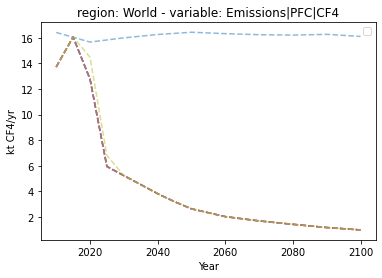

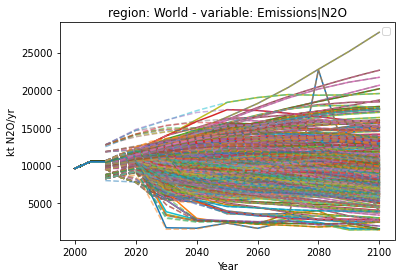

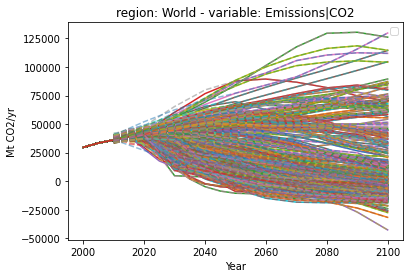

In [12]:
for var in ["*PFC|CF4", "*N2O", "*CO2"]:
    plt.figure()
    ax = plt.subplot()
    sr15_em_int_harm.filter(variable=var).plot(ax=ax)
    sr15_em_int.filter(variable=var).plot(ax=ax, linestyle="--", alpha=0.5)
    ax.legend("_")

In [13]:
sr15_em_int = sr15_em_int_harm

# Calculate pathways

In [14]:
try:
    del all_scens
except NameError:
    pass
baseyears = np.arange(2010, 2051, 5)
yeargap = 5
min_descent = 2025
max_descent = 2051
max_grad = 5000
overshoots = [0, -5000, -10000]
basis_scens = [
    sr15_em_int.filter(model="REMIND-MAgPIE 1.5", scenario="SSP5-Baseline", year=baseyears, variable="*CO2"),
    sr15_em_int.filter(model="AIM/CGE 2.0", scenario="SSP3-60", year=baseyears, variable="*CO2"),
    sr15_em_int.filter(model="MESSAGE-GLOBIOM 1.0", scenario="SSP2-45", year=baseyears, variable="*CO2"),
]
for basis_scen in basis_scens:
    scen_name = basis_scen.scenario[0]
    for mod_year in np.arange(min_descent, max_descent, yeargap):
        for net_zero in [i for i in np.arange(mod_year + 10, 2101, 10)] + [2150, 2200]:
            for overshoot in overshoots:
                scen = basis_scen.timeseries()
                for year in range(mod_year + yeargap, min(net_zero + 1, 2301), yeargap):
                    scen[year] = scen[mod_year] * (net_zero - year) / (net_zero - mod_year)
                for year in range(net_zero + yeargap, 2301, yeargap):
                    scen[year] = max([overshoot, scen[year - yeargap].values - max_grad])
                scen = scen.reset_index()
                scen["scenario"] = f"{scen_name}_ConstUntil{mod_year}_nz{net_zero}_ov{overshoot}"
                try:
                    all_scens = all_scens.append(scen)
                except NameError:
                    all_scens = scen
all_scens = pyam.IamDataFrame(all_scens)

In [15]:
sr15_em_int.filter(model="MESSAGE*", scenario="SSP2*")

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGE-GLOBIOM 1.0 (1)
 * scenario : SSP2-19, SSP2-26, SSP2-34, SSP2-45, SSP2-60, SSP2-Baseline (6)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|BC, Emissions|CH4, Emissions|CO, ... Emissions|VOC (13)
   unit     : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2/yr, ... Mt VOC/yr (11)
   year     : 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, ... 2100 (21)
Meta indicators:
   exclude (bool) False (1)

In [16]:
all_scens.model

['AIM/CGE 2.0', 'MESSAGE-GLOBIOM 1.0', 'REMIND-MAgPIE 1.5']

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: REMIND-MAgPIE 1.5 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

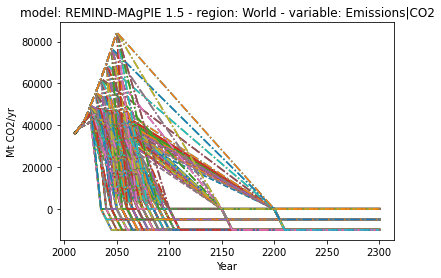

In [17]:
plt.figure()
ax = plt.subplot()
all_scens.filter(variable=co2tot, model=all_scens.model[0]).plot(ax=ax, linewidth=2)
all_scens.filter(variable=co2tot, model=all_scens.model[1]).plot(ax=ax, linestyle="--")
all_scens.filter(variable=co2tot, model=all_scens.model[2]).plot(ax=ax, linestyle="-.")

In [18]:
centyears = [year for year in all_scens.year if year <= 2100]

In [19]:
# Infill methane emissions
scenarios = []
methane_infiller = qrw.QuantileRollingWindows(sr15_em_int)
for methane_level in [0.1, 0.5, 0.9]:
    methane_scen = all_scens.copy().data
    methane_scen["scenario"] = methane_scen["scenario"] + "_meth{}".format(round(methane_level, 3))
    methane_vals = methane_infiller.derive_relationship(
        "Emissions|CH4", ["Emissions|CO2"], quantile=methane_level
    )(pyam.IamDataFrame(methane_scen).filter(year=centyears))
    scenarios.append(pyam.IamDataFrame(methane_scen))
    scenarios.append(methane_vals)

In [20]:
all_scens = pyam.concat(scenarios)

In [21]:
len(all_scens.timeseries())

2592

In [22]:
all_scens.timeseries()

2010  \
model             scenario                                        region variable      unit                      
AIM/CGE 2.0       SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.1  World  Emissions|CH4 Mt CH4/yr    370.896512   
                                                                         Emissions|CO2 Mt CO2/yr  36131.477195   
                  SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.5  World  Emissions|CH4 Mt CH4/yr    370.896512   
                                                                         Emissions|CO2 Mt CO2/yr  36131.477195   
                  SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.9  World  Emissions|CH4 Mt CH4/yr    370.896512   
...                                                                                                        ...   
REMIND-MAgPIE 1.5 SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.1 World  Emissions|CO2 Mt CO2/yr  36131.477195   
                  SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.5 World  Emissions|CH4 Mt CH4/yr    370.896512   
                                                                         Emissions|CO2 Mt CO2/yr  36131.477195   
                  SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.9 World  Emissions|CH4 Mt CH4/yr    370.896512   
                                                                         Emissions|CO2 Mt CO2/yr  36131.477195   

                                                                                                          2015  \
model             scenario                                        region variable      unit                      
AIM/CGE 2.0       SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.1  World  Emissions|CH4 Mt CH4/yr    388.072795   
                                                                         Emissions|CO2 Mt CO2/yr  39152.726298   
                  SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.5  World  Emissions|CH4 Mt CH4/yr    388.072795   
                                                                         Emissions|CO2 Mt CO2/yr  39152.726298   
                  SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.9  World  Emissions|CH4 Mt CH4/yr    388.072795   
...                                                                                                        ...   
REMIND-MAgPIE 1.5 SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.1 World  Emissions|CO2 Mt CO2/yr  39152.726298   
                  SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.5 World  Emissions|CH4 Mt CH4/yr    388.072795   
                                                                         Emissions|CO2 Mt CO2/yr  39152.726298   
                  SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.9 World  Emissions|CH4 Mt CH4/yr    388.072795   
                                                                         Emissions|CO2 Mt CO2/yr  39152.726298   

                                                                                                          2020  \
model             scenario                                        region variable      unit                      
AIM/CGE 2.0       SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.1  World  Emissions|CH4 Mt CH4/yr    385.326667   
                                                                         Emissions|CO2 Mt CO2/yr  42447.046681   
                  SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.5  World  Emissions|CH4 Mt CH4/yr    400.394746   
                                                                         Emissions|CO2 Mt CO2/yr  42447.046681   
                  SSP3-60_ConstUntil2025_nz2035_ov-10000_meth0.9  World  Emissions|CH4 Mt CH4/yr    413.201565   
...                                                                                                        ...   
REMIND-MAgPIE 1.5 SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.1 World  Emissions|CO2 Mt CO2/yr  43136.224014   
                  SSP5-Baseline_ConstUntil2050_nz2200_ov0_meth0.5 World  Emissions|CH4 Mt CH4/yr    402.636120   


In [23]:
co2_infiller = mi.SplitCollectionWithRemainderEmissions(sr15_em_int)
co2_breakdown = co2_infiller.infill_components(co2tot, [co2afolu], co2ei, all_scens.filter(year=centyears))

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Mt CO2/yr'>

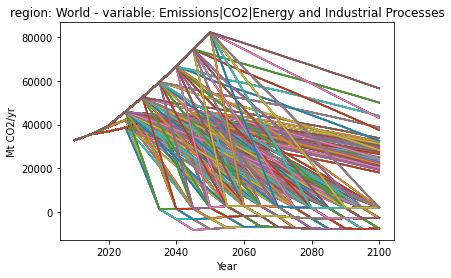

In [24]:
co2_breakdown.filter(variable=co2ei).plot()

In [25]:
all_scens=all_scens.append(co2_breakdown)

In [26]:
# Infill the remaining emissions
required_variables_list = [
            "Emissions|BC",
            "Emissions|CO",
            "Emissions|N2O",
            "Emissions|NH3",
            "Emissions|NOx",
            "Emissions|OC",
            "Emissions|Sulfur",
            "Emissions|VOC",
            "Emissions|HFC|HFC134a",
            "Emissions|HFC|HFC143a",
            "Emissions|HFC|HFC227ea",
            "Emissions|HFC|HFC23",
            "Emissions|HFC|HFC32",
            "Emissions|HFC|HFC43-10",
            "Emissions|HFC|HFC245fa",
            "Emissions|HFC|HFC125",
            "Emissions|SF6",
        ]
other_infilled = mi.infill_all_required_variables(all_scens.filter(year=centyears), sr15_em_int, 
                                                  [co2tot], required_variables_list=required_variables_list)

Filling required variables: 100%|██████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.03it/s]


In [27]:
# Infill the f-gases (these are not harmonized). We use additional smoothing in this because there are fewer scenarios
f_gases = [
    "Emissions|PFC|CF4",
    "Emissions|PFC|C2F6",
    "Emissions|PFC|C6F14",
]
other_infilled = mi.infill_all_required_variables(other_infilled, complete_sr15, [co2tot], required_variables_list=f_gases,
                                                  nwindows=5, decay_length_factor=2)

Filling required variables: 100%|████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.94s/it]


In [28]:
#for variable in other_infilled.variable:
#    other_infilled.filter(variable=variable).plot()

In [29]:
last_vals = other_infilled.filter(year=2100).filter(variable=[co2tot, co2ei], keep=False).data
all_years_extension = []
extend_years = [y for y in all_scens.year if y > 2100]
for year in extend_years:
    year_val = last_vals.copy()
    year_val["year"] = year
    all_years_extension.append(pyam.IamDataFrame(year_val))
extensions = pyam.concat(all_years_extension)
extensions

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, MESSAGE-GLOBIOM 1.0, REMIND-MAgPIE 1.5 (3)
 * scenario : SSP2-45_ConstUntil2025_nz2035_ov-10000_meth0.1, ... (1296)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|BC, Emissions|CH4, Emissions|CO, ... Emissions|VOC (22)
   unit     : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2/yr, Mt NH3/yr, ... kt SF6/yr (22)
   year     : 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, ... 2300 (40)
Meta indicators:
   exclude (bool) False (1)

In [30]:
extensions2 = extensions.append(all_scens.filter(year=extend_years))
extend_eni = extensions2.subtract(co2tot, co2afolu, co2ei, ignore_units=True)
extend_eni = extend_eni.rename(unit={"unknown": "Mt CO2/yr"})
extend_eni

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, MESSAGE-GLOBIOM 1.0, REMIND-MAgPIE 1.5 (3)
 * scenario : SSP2-45_ConstUntil2025_nz2035_ov-10000_meth0.1, ... (1296)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CO2|Energy and Industrial Processes (1)
   unit     : Mt CO2/yr (1)
   year     : 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, ... 2300 (40)
Meta indicators:
   exclude (bool) False (1)

In [31]:
other_infilled = pyam.concat([other_infilled, extensions2, extend_eni])

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

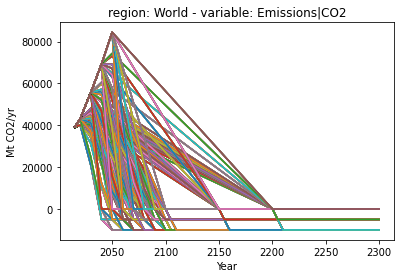

In [32]:
other_infilled.filter(variable=co2tot, scenario=["*ov-10000*", "*ov-5000*", "*ov0*"]).plot()

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Mt CO2/yr'>

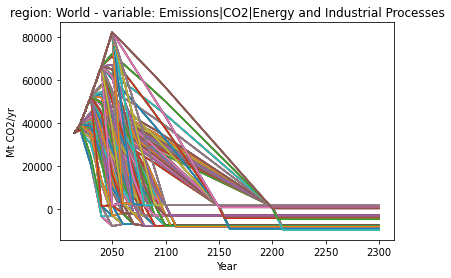

In [33]:
other_infilled.filter(variable=co2ei, scenario=["*ov-10000*", "*ov-5000*", "*ov0*"]).plot()

<AxesSubplot:xlabel='Year', ylabel='Value'>

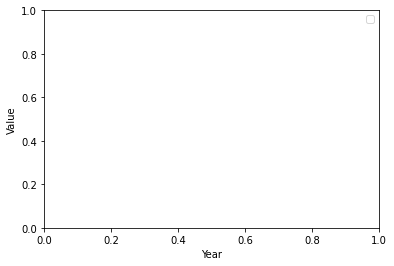

In [34]:
other_infilled.filter(variable=" *CH4", scenario=["*ov-10000*", "*ov-5000*", "*ov0*"]).plot()

In [35]:
csv_em_file = outdir + "scenarios_{}.csv"
scen_file = outdir + "scen_{}"
if not os.path.exists(outdir):
    os.makedirs(outdir)
other_infilled.to_csv(csv_em_file.format(version))

In [36]:
len(other_infilled.scenario)

1296

In [37]:
csv_em_file = outdir + "scenarios_{}.csv"
scen_file = outdir + "scen_{}"
other_infilled.to_csv(csv_em_file.format(version))

In [38]:
outdir

'../output/v8/tier3/'

In [39]:
def construct_scen_file(infilled_data, scen_file_name):
    """Function to construct scen file"""
    def rename_variables(v):
        """Format variables to MAGICC variable convention"""
        mapping = {
        'Emissions|HFC|HFC143a':'Emissions|HFC143a',
        'Emissions|HFC|HFC245ca':"Emissions|HFC245fa",
        'Emissions|CO2|AFOLU':'Emissions|CO2|MAGICC AFOLU',
        'Emissions|HFC|HFC43-10': 'Emissions|HFC4310',
        'Emissions|HFC|HFC32':'Emissions|HFC32',
        'Emissions|HFC|HFC125':'Emissions|HFC125',
        'Emissions|HFC|HFC227ea':'Emissions|HFC227ea',
        'Emissions|CO2|Energy and Industrial Processes': 'Emissions|CO2|MAGICC Fossil and Industrial',
        'Emissions|HFC|HFC134a':'Emissions|HFC134a',
        'Emissions|HFC|HFC23':'Emissions|HFC23',
        'Emissions|PFC|CF4': 'Emissions|CF4',
        'Emissions|PFC|C2F6': 'Emissions|C2F6',
        'Emissions|PFC|C6F14': 'Emissions|C6F14',
        'Emissions|Sulfur': 'Emissions|SOx',
        'Emissions|VOC':'Emissions|NMVOC'
        }
    
        try:
            return mapping[v]
        except KeyError:
            return v

    def replace_units(u):
        """Replace units for NOx"""
            
        mapping = {
            'Mt NOX/yr': 'Mt NO2 / yr',
        }
        try:
            return mapping[u]
        except KeyError:
            return u

    # Filter out HFC and non HFC - unit conversions
    non_hfc = infilled_data.filter(variable=["Emissions|HFC*", "Emissions|PFC*"], keep=False)
    hfc = infilled_data.filter(variable=["Emissions|HFC*", "Emissions|PFC*"]).data
    
    # Work around for HFC345ca
    hfc["unit"] = hfc["variable"].apply(
        lambda x: 
        "kt {} / yr".format(
            x
            .split("|")[-1]
            .replace("-", "")
            .replace("245ca", "245fa")
        )
    )
    hfc = pyam.IamDataFrame(hfc)
    enCO2 = non_hfc.filter(variable="Emissions|CO2|Energy and Industrial Processes").data
    enCO2["unit"] = "Mt CO2/yr"
    enCO2 = pyam.IamDataFrame(enCO2)
    non_hfc = non_hfc.filter(
        variable = "Emissions|CO2|Energy and Industrial Processes",
        keep = False
    ).append(enCO2)
    non_hfc = non_hfc.convert_unit("Mt NH3/yr", to="Mt N/yr", factor=14/17)

    # Create an SCM dataframe 
    scen_scm = scmdata.ScmRun(hfc.append(non_hfc))
    writer = pymagicc.io.MAGICCData(scen_scm)
    vars_not_used = [
        "Emissions|CO2", 
        "Emissions|F-Gases",
        'Emissions|kyotoghg_excl_lulucf'    
    ]
    writer = writer.filter(variable=vars_not_used, keep=False)
    # Check whether all the variables are named appropriately
    expected_names = [
        pymagicc.definitions.convert_magicc7_to_openscm_variables(f"{v}_EMIS") 
        for v in pymagicc.definitions.PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1
    ]

    writer["variable"] = writer["variable"].apply(rename_variables)
    writer["unit"] = writer["unit"].apply(replace_units)
    writer["todo"] = "SET"
        
    missing_names = set(expected_names) - set(writer["variable"].unique())
    assert not missing_names, missing_names
    problematic_names = set(writer["variable"].unique()) - set(expected_names)
    assert not problematic_names, problematic_names

    # Unit conversion and cleaning 
    unit_specs = pymagicc.definitions.MAGICC7_EMISSIONS_UNITS.set_index("magicc_variable")
    for v in writer["variable"]:
            magicc_var = pymagicc.definitions.convert_magicc7_to_openscm_variables(
                v, inverse=True).replace("T_EMIS", "").replace("_EMIS", "")
            magicc_unit = unit_specs.loc[magicc_var, "emissions_unit"]
            writer = writer.convert_unit(magicc_unit, variable=v)
    
    # Now we add the 2000 data from the SR1.5 SCEN files to ensure MAGICC doesn't
    # assume constant emissions between 2000 and the start of the SCEN file
    base_scen_file = os.path.join(
        os.path.dirname(os.path.abspath("__file__")),
        "..",
        "sr15_scenfiles",
        "scenfiles",
        "IPCCSR15_REMIND-MAgPIE 1.7-3.0_PEP_2C_red_netzero_GAS.SCEN",
    )
    extra_hist = pymagicc.io.MAGICCData(base_scen_file).filter(
        year = range(1, writer["year"].min()),
        region = "World"
    )

    # Overwrite model, scenario names
    extra_hist["scenario"] = writer.get_unique_meta("scenario",True)
    extra_hist["model"] = writer.get_unique_meta("model", True)
    extra_hist["unit"] = extra_hist["unit"].apply(
        lambda x: (
            x
            .replace("134a", "134A")
            .replace("143a", "143A")
            .replace("245fa", "245FA")
            .replace("227ea", "227EA")
        )
    )

    writer = pymagicc.io.MAGICCData(pd.concat(
        [
            extra_hist.timeseries(time_axis="year", meta=writer.timeseries().index.names),
            writer.timeseries(time_axis="year"),
        ],
        axis=1,
    ))
    # Write the scen file
    writer.write("{}.SCEN".format(scen_file_name), magicc_version=6)

In [40]:
#for scenario in other_infilled.scenario:
#    construct_scen_file(other_infilled.filter(scenario=scenario), scen_file.format(scenario))